In [1]:
# Pandas dataframe
import pandas as pd
from pandas import DataFrame

# Scikit-Learn
import sklearn 
from sklearn import datasets, linear_model, metrics, tree
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score

# Models
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import (BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, 
RandomForestRegressor, AdaBoostRegressor)
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
        
import joblib
from matplotlib import pyplot as plt
import numpy as np
import os
from tqdm import tqdm

In [2]:
df_abs = pd.read_csv("dataset_scaled_abs.csv")
df_abs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 77 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Unnamed: 0                                    205 non-null    int64  
 1   in_amount_mmol                                205 non-null    float64
 2   p_amount_mmol                                 205 non-null    float64
 3   ligand_amount_mmol                            205 non-null    float64
 4   first_sol_amount_ml                           205 non-null    float64
 5   second_sol_amount_ml                          205 non-null    float64
 6   other_1_amount_mmol                           205 non-null    float64
 7   other_2_amount_mmol                           205 non-null    float64
 8   total_volume_ml                               205 non-null    float64
 9   temp_c                                        205 non-null    flo

In [4]:
#Checks the column names, and ensures that they do not have any leading or trailing spaces
df_abs.columns = df_abs.columns.str.strip()

In [7]:
# Input for ML models

input_col = ['in_amount_mmol', 'p_amount_mmol', 'ligand_amount_mmol',
       'first_sol_amount_ml', 'second_sol_amount_ml', 
       'other_1_amount_mmol', 'other_2_amount_mmol', 'total_volume_ml',
       'temp_c', 'time_min', 'x0_chloroindium oxalate', 'x0_indium acetate',
       'x0_indium bromide', 'x0_indium chloride', 'x0_indium iodide',
       'x0_indium myristate', 'x0_indium oxalate', 'x0_indium palmitate',
       'x0_indium trifluoroacetate',
       'x0_indium tris(N,N-diisopropylacetamidinato)',
       'x1_bis(trimethylsilyl)phosphine', 'x1_phosphine gas',
       'x1_phosphorus trichloride', 'x1_sodium phosphide',
       'x1_tris(diethylamino)phosphine', 'x1_tris(dimethylamino)phosphine',
       'x1_tris(trimethylgermyl)phosphine', 'x1_tris(trimethylsilyl)phosphine',
       'x1_white phosphorus', 'x2_None', 'x2_dodecanethiol', 'x2_lauric acid',
       'x2_myristic acid', 'x2_oleic acid', 'x2_palmitic acid',
       'x2_stearic acid', 'x3_4-ethylpyridine', 'x3_None',
       'x3_dimethylformamide', 'x3_dodecylamine', 'x3_mesitylene',
       'x3_octadecene', 'x3_oleylamine', 'x3_trioctylamine',
       'x3_trioctylphosphine', 'x3_trioctylphosphine oxide', 'x4_None',
       'x4_dioctyl ether', 'x4_dioctylamine', 'x4_hexadecylamine',
       'x4_octylamine', 'x4_oleylamine', 'x4_toluene', 'x4_trioctylphosphine',
       'x4_trioctylphosphine oxide', 
       'x5_None', 'x5_acetic acid', 'x5_superhydride',
       'x5_tetrabutylammonium myristate', 'x5_zinc acetate', 'x5_zinc bromide',
       'x5_zinc chloride', 'x5_zinc iodide', 'x5_zinc octanoate',
       'x5_zinc oleate', 'x5_zinc stearate', 'x5_zinc undecylenate', 'x6_None',
       'x6_copper bromide', 'x6_oleic acid','x6_trioctylphosphine',  'x6_water', 'x6_zinc iodide']

output_col = ['abs_nm']

X = df_abs[input_col]

Y = df_abs[output_col]

In [8]:
# Splitting dataset for training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=45, shuffle=True)

# Hyper parameter tuning
## Ensemble regressors

### Bagging

In [24]:
%%time

#sklearn random search over n iterations
#define ranges of paramaters to tune
#the internet tunes these parameters for bagging

params = {'n_estimators': range(10,1001)}

#n_jobs runs jobs in parallel, verbose prints updates in command line
rs_bag = RandomizedSearchCV(BaggingRegressor(), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_bag.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_bag.best_score_)
print('Best Parameters : ',rs_bag.best_params_)

Fitting 5 folds for each of 820 candidates, totalling 4100 fits
Best MAE Score Through Random Search : -30.799
Best Parameters :  {'n_estimators': 28, 'random_state': 4}
CPU times: user 6.57 s, sys: 440 ms, total: 7.01 s
Wall time: 1min 23s


Mean absolute error = 26.96 nm


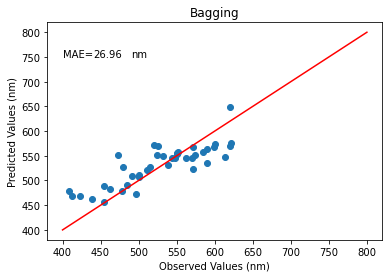

In [10]:
#using random search parameters
B_regr = BaggingRegressor(n_estimators=12)
B_regr.fit(X_train, np.ravel(Y_train))
            
B_Y_pred = B_regr.predict(X_test)
            
B_mae = mean_absolute_error(Y_test, B_Y_pred)
print("Mean absolute error =", round(B_mae,3), 'nm')

plt.figure()
plt.title("Bagging")
plt.plot(Y_test, B_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(B_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Random Forest

In [33]:
%%time

#sklearn random search

params = {'n_estimators': range(100,1001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_rf = RandomizedSearchCV(RandomForestRegressor(), param_distributions=params, n_iter=500, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_rf.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_rf.best_score_)
print('Best Parameters : ',rs_rf.best_params_)

Fitting 5 folds for each of 1020 candidates, totalling 5100 fits
Best MAE Score : -31.223
Best Parameters :  {'n_estimators': 123, 'random_state': 14}
CPU times: user 15.5 s, sys: 1.08 s, total: 16.6 s
Wall time: 5min 50s


Mean absolute error = 25.775 nm


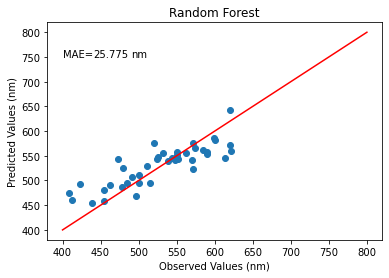

In [13]:
#using random search parameters
RF_regr = RandomForestRegressor(n_estimators=157)
RF_regr.fit(X_train, np.ravel(Y_train))
            
RF_Y_pred = RF_regr.predict(X_test)
            
RF_mae = mean_absolute_error(Y_test, RF_Y_pred)
print("Mean absolute error =", round(RF_mae,3), 'nm')

plt.figure()
plt.title("Random Forest")
plt.plot(Y_test, RF_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(RF_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Decision Tree

In [27]:
%%time

#sklearn random search

params = {'min_samples_split': range(2,100),
          'min_samples_leaf':range(1,100)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_dt = RandomizedSearchCV(DecisionTreeRegressor(), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_dt.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_dt.best_score_)
print('Best Parameters : ',rs_dt.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -40.880
Best Parameters :  {'min_samples_split': 49, 'min_samples_leaf': 1}
CPU times: user 2.87 s, sys: 131 ms, total: 3 s
Wall time: 8.48 s


Mean absolute error = 25.427 nm


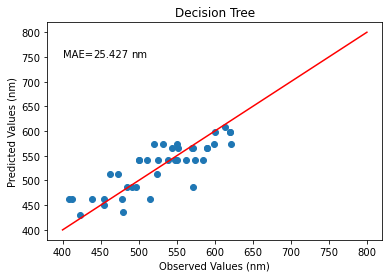

In [16]:
#using random search parameters
DT_regr = DecisionTreeRegressor(min_samples_leaf=1, min_samples_split=49)
DT_regr.fit(X_train, np.ravel(Y_train))
            
DT_Y_pred = DT_regr.predict(X_test)
            
DT_mae = mean_absolute_error(Y_test, DT_Y_pred)
print("Mean absolute error =", round(DT_mae,3), 'nm')

plt.figure()
plt.title("Decision Tree")
plt.plot(Y_test, DT_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(DT_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Extra Trees

In [30]:
%%time

#sklearn random search

params = {'n_estimators': range(100,1001),
          'min_samples_split':range(2,10),
         'min_samples_leaf': range(1,10)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_et = RandomizedSearchCV(ExtraTreesRegressor(), param_distributions=params, n_iter=500, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_et.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_et.best_score_)
print('Best Parameters : ',rs_et.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best MAE Score Through Random Search : -38.628
Best Parameters :  {'n_estimators': 466, 'min_samples_split': 3, 'min_samples_leaf': 1}
CPU times: user 8.39 s, sys: 435 ms, total: 8.82 s
Wall time: 8min 24s


In [7]:
%%time

#after first optimisation, now looking for best random state

params = {'random_state':range(1,1001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_et = RandomizedSearchCV(ExtraTreesRegressor(n_estimators=466, min_samples_split=3, min_samples_leaf=1), 
                           param_distributions=params, n_iter=200, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_et.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_et.best_score_)
print('Best Parameters : ',rs_et.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best MAE Score Through Random Search : -38.366
Best Parameters :  {'random_state': 90}
CPU times: user 3.78 s, sys: 212 ms, total: 3.99 s
Wall time: 3min 21s


Mean absolute error = 22.269 nm


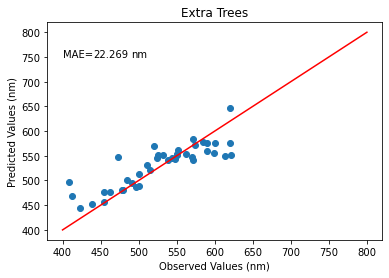

In [9]:
ET_regr = ExtraTreesRegressor(n_estimators=466, min_samples_split=3, min_samples_leaf=1, random_state=90)
            
ET_regr.fit(X_train, np.ravel(Y_train))
            
ET_Y_pred = ET_regr.predict(X_test)
            
ET_mae = mean_absolute_error(Y_test, ET_Y_pred)
print("Mean absolute error =", round(ET_mae,3), 'nm')

plt.figure()
plt.title("Extra Trees")
plt.plot(Y_test, ET_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(ET_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Ada Boost

In [36]:
%%time

#sklearn random search

params = {'n_estimators': range(50,501),
          'learning_rate':range(1,11),
         'loss':['linear', 'square', 'exponential']}

#n_jobs runs jobs in parallel, verbose prints updates
rs_ab = RandomizedSearchCV(AdaBoostRegressor(), param_distributions=params, n_iter=100, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_ab.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_ab.best_score_)
print('Best Parameters : ',rs_ab.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best MAE Score Through Random Search : -39.135
Best Parameters :  {'n_estimators': 374, 'loss': 'exponential', 'learning_rate': 4}
CPU times: user 4.6 s, sys: 267 ms, total: 4.87 s
Wall time: 1min 13s


Mean absolute error = 33.927 nm


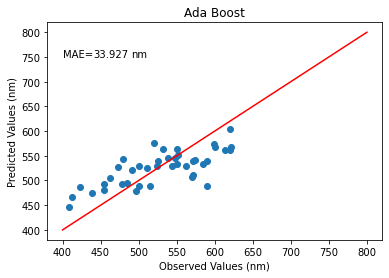

In [23]:
AB_regr = AdaBoostRegressor(n_estimators=374, loss='exponential', learning_rate=4)
            
AB_regr.fit(X_train, np.ravel(Y_train))
AB_Y_pred = AB_regr.predict(X_test)
            
AB_mae = mean_absolute_error(Y_test, AB_Y_pred)
print("Mean absolute error =", round(AB_mae,3), 'nm')

plt.figure()
plt.title("Ada Boost")
plt.plot(Y_test, AB_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(AB_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Gradient Boosting

In [32]:
%%time

#sklearn random search

params = {'n_estimators': range(100,1001),
          'min_samples_split':range(2,21),
         'min_samples_leaf': range(1,11),
         'max_depth':range(3,31)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_gb = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=params, n_iter=100, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_gb.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_gb.best_score_)
print('Best Parameters : ',rs_gb.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best MAE Score Through Random Search : -37.084
Best Parameters :  {'n_estimators': 210, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 7}
CPU times: user 2.33 s, sys: 361 ms, total: 2.69 s
Wall time: 1min 26s


In [62]:
%%time

#sklearn random search

params = {'random_state':range(1,1001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_gb = RandomizedSearchCV(GradientBoostingRegressor(n_estimators=210, min_samples_split=10, min_samples_leaf=1, max_depth=7), param_distributions=params, n_iter=500, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_gb.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_gb.best_score_)
print('Best Parameters : ',rs_gb.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best MAE Score Through Random Search : -36.905
Best Parameters :  {'random_state': 179}
CPU times: user 6.58 s, sys: 313 ms, total: 6.9 s
Wall time: 1min 56s


Mean absolute error = 24.469 nm


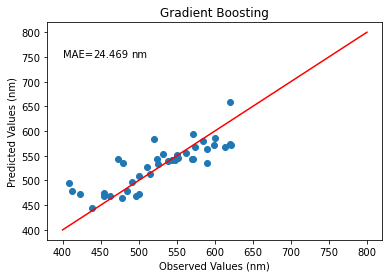

In [26]:
GB_regr = GradientBoostingRegressor(n_estimators=210, min_samples_split=10, min_samples_leaf=1, max_depth=7)
            
GB_regr.fit(X_train, np.ravel(Y_train))
GB_Y_pred = GB_regr.predict(X_test)
            
GB_mae = mean_absolute_error(Y_test, GB_Y_pred)
print("Mean absolute error =", round(GB_mae,3), 'nm')

plt.figure()
plt.title("Gradient Boosting")
plt.plot(Y_test, GB_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(GB_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

## Others

### Linear Regression

Mean absolute error = 28596716743423.453 nm


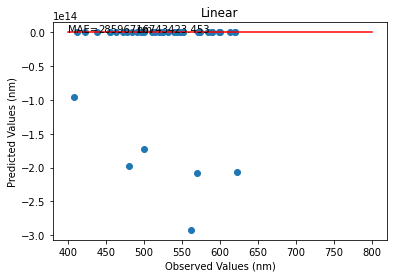

In [59]:
#using random search parameters
Linear_regr = LinearRegression()
Linear_regr.fit(X_train, np.ravel(Y_train))
            
Linear_Y_pred = Linear_regr.predict(X_test)
            
Linear_mae = mean_absolute_error(Y_test, Linear_Y_pred)
print("Mean absolute error =", round(Linear_mae,3), 'nm')

plt.figure()
plt.title("Linear")
plt.plot(Y_test, Linear_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(Linear_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Lasso

In [39]:
%%time

#sklearn random search over n iterations

params = {'max_iter': range(1000,10001),
         'selection': ['cyclic', 'random']}

#n_jobs runs jobs in parallel, verbose prints updates
rs_lasso = RandomizedSearchCV(Lasso(), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_lasso.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_lasso.best_score_)
print('Best Parameters : ',rs_lasso.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -42.732
Best Parameters :  {'selection': 'random', 'max_iter': 2099}
CPU times: user 2.87 s, sys: 142 ms, total: 3.01 s
Wall time: 9.89 s


Mean absolute error = 37.398 nm


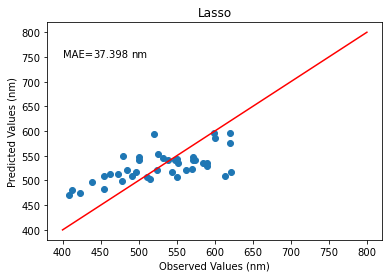

In [29]:
#using random search parameters
Lasso_regr = Lasso(selection='random', max_iter=2099)
Lasso_regr.fit(X_train, np.ravel(Y_train))
            
Lasso_Y_pred = Lasso_regr.predict(X_test)
            
Lasso_mae = mean_absolute_error(Y_test, Lasso_Y_pred)
print("Mean absolute error =", round(Lasso_mae,3), 'nm')

plt.figure()
plt.title("Lasso")
plt.plot(Y_test, Lasso_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(Lasso_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### ElasticNet

In [41]:
%%time

#sklearn random search over n iterations

params = {'max_iter': range(1000,10001),
         'selection': ['cyclic', 'random']}

#n_jobs runs jobs in parallel, verbose prints updates
rs_en = RandomizedSearchCV(ElasticNet(), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_en.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_en.best_score_)
print('Best Parameters : ',rs_en.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -44.918
Best Parameters :  {'selection': 'random', 'max_iter': 4612}
CPU times: user 3.12 s, sys: 314 ms, total: 3.43 s
Wall time: 11 s


Mean absolute error = 44.245 nm


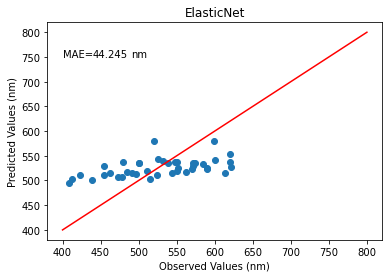

In [32]:
#using random search parameters
EN_regr = ElasticNet(selection='random', max_iter=4612)
EN_regr.fit(X_train, np.ravel(Y_train))
            
EN_Y_pred = EN_regr.predict(X_test)
            
EN_mae = mean_absolute_error(Y_test, EN_Y_pred)
print("Mean absolute error =", round(EN_mae,3), 'nm')

plt.figure()
plt.title("ElasticNet")
plt.plot(Y_test, EN_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(EN_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Ridge

Mean absolute error = 30.96 nm


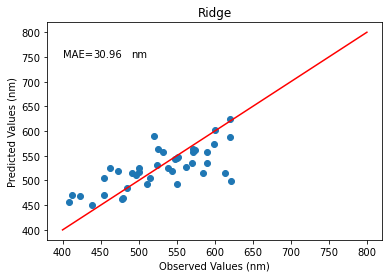

In [35]:
#using random search parameters
Ridge_regr = Ridge(solver='saga')
Ridge_regr.fit(X_train, np.ravel(Y_train))
            
Ridge_Y_pred = Ridge_regr.predict(X_test)
            
Ridge_mae = mean_absolute_error(Y_test, Ridge_Y_pred)
print("Mean absolute error =", round(Ridge_mae,3), 'nm')

plt.figure()
plt.title("Ridge")
plt.plot(Y_test, Ridge_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(Ridge_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### SVR kernel='linear'

In [53]:
%%time

#sklearn random search over n iterations

params = {'degree':range(1,10),
         'cache_size':range(200,2001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_svrlin = RandomizedSearchCV(SVR(kernel='linear'), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_svrlin.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_svrlin.best_score_)
print('Best Parameters : ',rs_svrlin.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -44.624
Best Parameters :  {'degree': 3, 'cache_size': 927}
CPU times: user 3.02 s, sys: 218 ms, total: 3.24 s
Wall time: 12.4 s


Mean absolute error = 43.534 nm


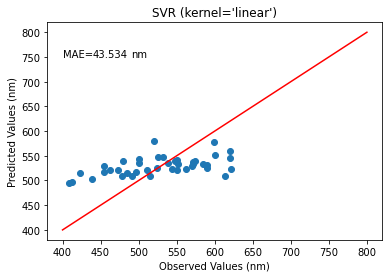

In [37]:
#using random search parameters
SVRlin_regr = SVR(kernel='linear', degree=3, cache_size=927)
SVRlin_regr.fit(X_train, np.ravel(Y_train))
            
SVRlin_Y_pred = SVRlin_regr.predict(X_test)
            
SVRlin_mae = mean_absolute_error(Y_test, SVRlin_Y_pred)
print("Mean absolute error =", round(SVRlin_mae,3), 'nm')

plt.figure()
plt.title("SVR (kernel='linear')")
plt.plot(Y_test, SVRlin_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(SVRlin_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### SVR kernel='rbf'

In [55]:
%%time

#sklearn random search over n iterations

params = {'degree':range(1,10),
         'cache_size':range(200,2001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_svrrbf = RandomizedSearchCV(SVR(kernel='rbf'), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_svrrbf.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_svrrbf.best_score_)
print('Best Parameters : ',rs_svrrbf.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -49.380
Best Parameters :  {'degree': 2, 'cache_size': 1675}
CPU times: user 2.63 s, sys: 127 ms, total: 2.76 s
Wall time: 11.7 s


Mean absolute error = 48.333 nm


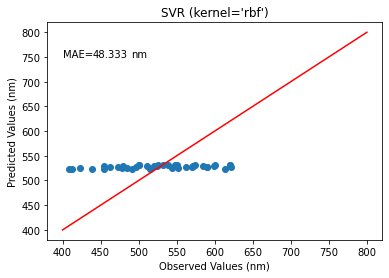

In [57]:
#using random search parameters
SVRrbf_regr = SVR(kernel='rbf')
SVRrbf_regr.fit(X_train, np.ravel(Y_train))
            
SVRrbf_Y_pred = SVRrbf_regr.predict(X_test)
            
SVRrbf_mae = mean_absolute_error(Y_test, SVRrbf_Y_pred)
print("Mean absolute error =", round(SVRrbf_mae,3), 'nm')

plt.figure()
plt.title("SVR (kernel='rbf')")
plt.plot(Y_test, SVRrbf_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(SVRrbf_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

## Conclusion

Extra Trees gave the best performance, **n_estimators=466, min_samples_split=3, min_samples_leaf=1, random_state=609**

## Saving model

In [64]:
ET_regr = ExtraTreesRegressor(n_estimators=466, min_samples_split=3, min_samples_leaf=1, random_state=609)

ET_regr.fit(X_train, np.ravel(Y_train))
ET_Y_pred = ET_regr.predict(X_test)

joblib.dump(ET_regr, "./model_aug_abs_ExtraTrees.joblib")

['./model_aug_abs_ExtraTrees.joblib']

## Grid search 10/26/2021

### Bagging


In [8]:
min_mae = 99999

min_i, min_j, min_k  = 0, 0, 0

for i in tqdm(range(1, 20)):
    for j in range(1, 20):
        for k in range(2, 40, 2):
            
            B_regr = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=i),
                                      n_estimators=j,
                                      random_state=k)
            
            B_regr.fit(X_train, np.ravel(Y_train))
            
            B_Y_pred = B_regr.predict(X_test)
            
            mae = mean_absolute_error(Y_test, B_Y_pred)
            
            if (min_mae > mae):
                min_mae = mae
                min_i = i
                min_j = j
                min_k = k
            
print(min_mae, min_i, min_j, min_k)

100%|██████████| 19/19 [02:41<00:00,  8.48s/it]

22.910238541945862 13 5 28


### Random Forest

In [12]:
min_mae = 99999
min_i, min_j, min_k = 0, 0, 0
for i in tqdm(range(1, 30)):
    for j in range(1, 30):
        for k in range(2, 40, 2):
            RF_regr = RandomForestRegressor(max_depth=i, 
                                            n_estimators=j, 
                                            max_features=k,
                                            random_state=45
                                                )
            RF_regr.fit(X_train, np.ravel(Y_train))
            RF_Y_pred = RF_regr.predict(X_test)

            mae = mean_absolute_error(Y_test, RF_Y_pred)
            if (min_mae > mae):
                min_mae = mae
                min_i = i
                min_j = j
                min_k = k
            
print(min_mae, min_i, min_j, min_k)

100%|██████████| 29/29 [06:12<00:00, 12.86s/it]

24.838075880758808 20 3 30


### Decision Tree

In [10]:
min_mae = 99999

min_i, min_j, min_k  = 0, 0, 0

for i in tqdm(range(1, 30)):
    for j in range(1, 30):
        for k in range(2, 40, 2):
            
            DT_regr = DecisionTreeRegressor(max_depth=i,
                                max_features=j,
                                random_state=k)
            
            DT_regr.fit(X_train, Y_train)

            DT_Y_pred = DT_regr.predict(X_test)

            mae = mean_absolute_error(Y_test, DT_Y_pred)
            
            if (min_mae > mae):
                min_mae = mae
                min_i = i
                min_j = j
                min_k = k
            
print(min_mae, min_i, min_j, min_k)

100%|██████████| 29/29 [01:25<00:00,  2.95s/it]

20.3150406504065 19 28 16


### Extra Trees

In [9]:
min_mae = 99999
min_i, min_j, min_k = 0, 0, 0
for i in tqdm(range(1, 30)):
    for j in range(1, 30):
        for k in range(2, 50, 2):
            ET_regr = ExtraTreesRegressor(n_estimators=i, 
                                            max_features=j,
                                            random_state=k
                                                )
            ET_regr.fit(X_train, np.ravel(Y_train))
            ET_Y_pred = ET_regr.predict(X_test)

            mae = mean_absolute_error(Y_test, ET_Y_pred)
            if (min_mae > mae):
                min_mae = mae
                min_i = i
                min_j = j
                min_k = k
            
print(min_mae, min_i, min_j, min_k)

100%|██████████| 29/29 [07:29<00:00, 15.51s/it]

20.29268292682927 2 28 34


### AdaBoost

In [11]:
min_mae = 99999
min_i, min_j = 0, 0
for i in tqdm(range(1, 30)):
    for j in range(1, 30):
        AB_regr = AdaBoostRegressor(n_estimators=i, loss='exponential', learning_rate=j)
        AB_regr.fit(X_train, np.ravel(Y_train))
        AB_Y_pred = AB_regr.predict(X_test)
        AB_mae = mean_absolute_error(Y_test, AB_Y_pred)
        if (min_mae > mae):
                min_mae = mae
                min_i = i
                min_j = j
print(min_mae, min_i, min_j)

100%|██████████| 29/29 [00:17<00:00,  1.67it/s]

36.390243902439025 1 1


### Gradient Boosting

In [13]:
min_mae = 999
min_i, min_j, min_k, min_l = 0, 0, 0.0, 0
for i in tqdm(range(300, 450, 10)):
    for j in range(2, 30, 2):
        for k in np.arange(0.06, 0.22, 0.02):
            for l in range(2, 22, 2):
                GB_regr = GradientBoostingRegressor(n_estimators=i, max_depth=j, learning_rate=k, random_state=l)
                GB_regr.fit(X_train, np.ravel(Y_train))
                GB_Y_pred = GB_regr.predict(X_test)

                mae = mean_absolute_error(Y_test, GB_Y_pred)
                if (min_mae > mae):
                    min_mae = mae
                    min_i = i
                    min_j = j
                    min_k = k
                    min_l = l

print(min_mae, min_i, min_j, min_k, min_l)

  0%|          | 0/15 [04:25<?, ?it/s]


KeyboardInterrupt: 

## Saving Extra Trees model

In [13]:
ET_regr = ExtraTreesRegressor(n_estimators=2, 
                            max_features=28,
                            random_state=34)

ET_regr.fit(X_train, np.ravel(Y_train))
ET_Y_pred = ET_regr.predict(X_test)

joblib.dump(ET_regr, "./model_aug_abs_ExtraTrees.joblib")

['./model_aug_abs_ExtraTrees.joblib']